Idea
1. Load annotation masks
2. Extract geometric features 
3. GridSearchCV
4. Compare performance

In [14]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = os.getcwd()
TRAIN_DIR = os.path.join(BASE_DIR, 'training_set')
TRAIN_CSV = os.path.join(BASE_DIR, 'training_set_pixel_size_and_HC.csv')

## 1. Extract Geometric Features from Masks

In [15]:
def extract_mask_features(mask_path, pixel_size):
    """
    Extract geometric features from annotation mask
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) == 0:
        return None
    
    contour = max(contours, key=cv2.contourArea)
    
    area_pixels = cv2.contourArea(contour)
    perimeter_pixels = cv2.arcLength(contour, closed=True)
    
    x, y, w, h = cv2.boundingRect(contour)
    
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        (cx, cy), (MA, ma), angle = ellipse
        MA, ma = max(MA, ma), min(MA, ma)
        eccentricity = np.sqrt(1 - (ma/MA)**2) if MA > 0 else 0
    else:
        MA, ma, eccentricity = 0, 0, 0
    
    moments = cv2.moments(contour)
    
    features = {
        'area_mm2': area_pixels * (pixel_size ** 2),
        'perimeter_mm': perimeter_pixels * pixel_size,
        'bbox_width_mm': w * pixel_size,
        'bbox_height_mm': h * pixel_size,
        'bbox_aspect_ratio': w / h if h > 0 else 0,
        'solidity': area_pixels / hull_area if hull_area > 0 else 0,
        'extent': area_pixels / (w * h) if (w * h) > 0 else 0,
        'major_axis_mm': MA * pixel_size,
        'minor_axis_mm': ma * pixel_size,
        'eccentricity': eccentricity,
        'hu_moment_1': moments['mu20'] if 'mu20' in moments else 0,
        'hu_moment_2': moments['mu02'] if 'mu02' in moments else 0,
        'circularity': (4 * np.pi * area_pixels) / (perimeter_pixels ** 2) if perimeter_pixels > 0 else 0,
    }
    
    return features

print("Feature extraction function ready")

Feature extraction function ready


## 2. Load Data and Extract Features

In [16]:
df = pd.read_csv(TRAIN_CSV)
print(f"Total samples: {len(df)}")

features_list = []
targets = []

for idx, row in df.iterrows():
    filename = row['filename']
    mask_filename = filename.replace('_HC.png', '_HC_Annotation.png')
    mask_path = os.path.join(TRAIN_DIR, mask_filename)
    
    if os.path.exists(mask_path):
        features = extract_mask_features(mask_path, row['pixel size(mm)'])
        if features is not None:
            features_list.append(features)
            targets.append(row['head circumference (mm)'])

X = pd.DataFrame(features_list)
y = np.array(targets)

print(f"Extracted features from {len(X)} samples")
print(f"\nFeature columns:")
print(X.columns.tolist())
print(f"\nFeature statistics:")
print(X.describe())

Total samples: 999
Extracted features from 999 samples

Feature columns:
['area_mm2', 'perimeter_mm', 'bbox_width_mm', 'bbox_height_mm', 'bbox_aspect_ratio', 'solidity', 'extent', 'major_axis_mm', 'minor_axis_mm', 'eccentricity', 'hu_moment_1', 'hu_moment_2', 'circularity']

Feature statistics:
          area_mm2  perimeter_mm  bbox_width_mm  bbox_height_mm  \
count   999.000000    999.000000     999.000000      999.000000   
mean   2204.635737    176.706439      57.712554       43.110019   
std    2004.519302     83.251757      24.091760       21.622157   
min       5.654335     14.694432       1.017307        1.489737   
25%     438.933264    117.772863      40.998412       24.762250   
50%    2248.102759    181.571434      60.707952       47.205167   
75%    2612.110317    196.421759      66.184862       51.945594   
max    9480.589678    877.114528     122.315650      111.486666   

       bbox_aspect_ratio    solidity      extent  major_axis_mm  \
count         999.000000  999.000

## 3. Train-Test Split and Scaling

In [17]:
print(f"Checking for NaN values:")
print(X.isnull().sum())

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Checking for NaN values:
area_mm2             0
perimeter_mm         0
bbox_width_mm        0
bbox_height_mm       0
bbox_aspect_ratio    0
solidity             0
extent               0
major_axis_mm        0
minor_axis_mm        0
eccentricity         0
hu_moment_1          0
hu_moment_2          0
circularity          0
dtype: int64
Train: 799 | Test: 200


## 4. GridSearchCV with Multiple Models

In [18]:
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.01, 0.1, 1.0],
            'kernel': ['rbf', 'linear']
        }
    }
}

results = {}

for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)
    
    X_use = X_train_scaled if name in ['Ridge', 'SVR'] else X_train
    X_test_use = X_test_scaled if name in ['Ridge', 'SVR'] else X_test
    
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_use, y_train)
    
    y_pred = grid.predict(X_test_use)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'best_params': grid.best_params_,
        'best_model': grid.best_estimator_,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"Best params: {grid.best_params_}")
    print(f"MAE: {mae:.2f}mm")
    print(f"R2: {r2:.4f}")


Training RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
MAE: 5.31mm
R2: 0.9528

Training GradientBoosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
MAE: 6.69mm
R2: 0.9254

Training Ridge...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'alpha': 10.0}
MAE: 7.71mm
R2: 0.9314

Training SVR...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'C': 10.0, 'epsilon': 0.01, 'kernel': 'linear'}
MAE: 5.95mm
R2: 0.9367


## 5. Results Comparison

In [19]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE (mm)': [results[m]['mae'] for m in results.keys()],
    'R2': [results[m]['r2'] for m in results.keys()]
}).sort_values('MAE (mm)')

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

best_model_name = comparison_df.iloc[0]['Model']
best_mae = comparison_df.iloc[0]['MAE (mm)']
print(f"\nBest model: {best_model_name} (MAE: {best_mae:.2f}mm)")


RESULTS SUMMARY
           Model  MAE (mm)       R2
    RandomForest  5.313580 0.952829
             SVR  5.949640 0.936685
GradientBoosting  6.693080 0.925387
           Ridge  7.708294 0.931403

Best model: RandomForest (MAE: 5.31mm)


## 6. Visualize Best Model

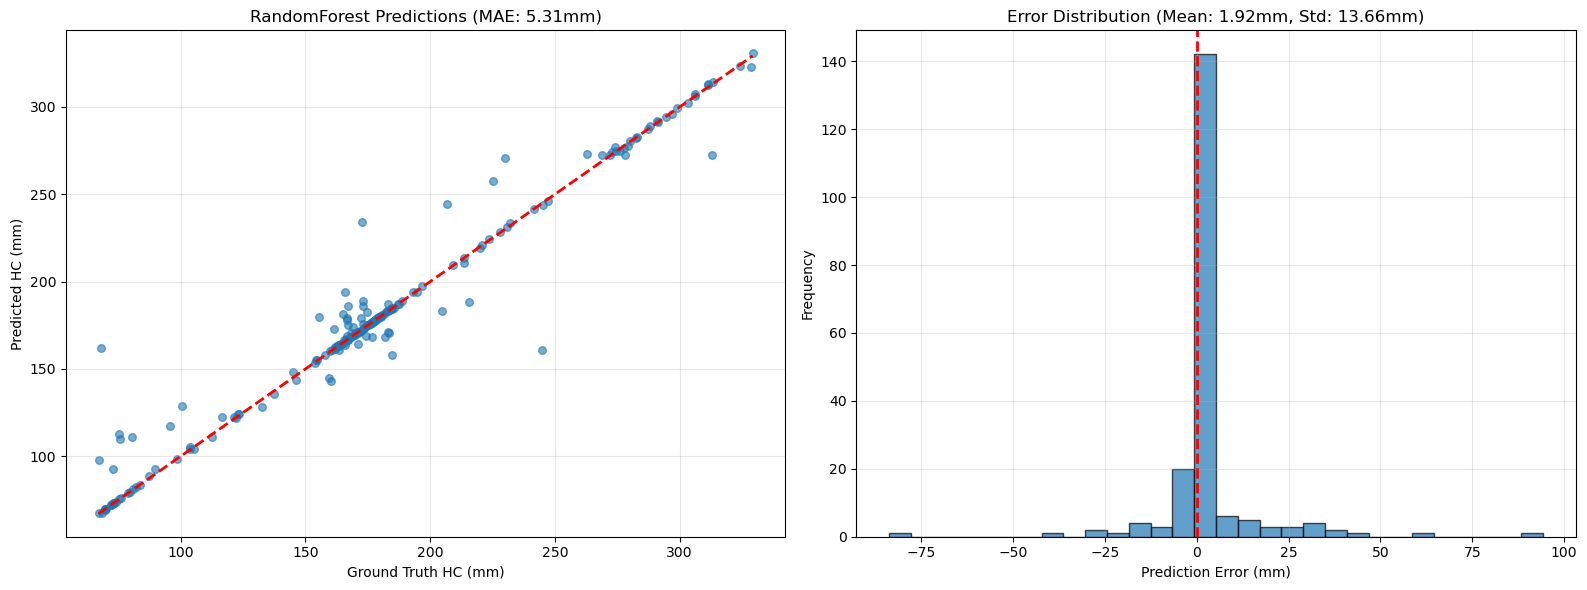

In [20]:
import matplotlib.pyplot as plt

best_predictions = results[best_model_name]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test, best_predictions, alpha=0.6, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Ground Truth HC (mm)')
axes[0].set_ylabel('Predicted HC (mm)')
axes[0].set_title(f'{best_model_name} Predictions (MAE: {best_mae:.2f}mm)')
axes[0].grid(True, alpha=0.3)

errors = best_predictions - y_test
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Prediction Error (mm)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Error Distribution (Mean: {errors.mean():.2f}mm, Std: {errors.std():.2f}mm)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis


Feature Importances:
          Feature  Importance
    bbox_width_mm    0.536359
    major_axis_mm    0.296969
     perimeter_mm    0.038068
      hu_moment_1    0.037428
      circularity    0.022577
      hu_moment_2    0.017275
         solidity    0.015783
         area_mm2    0.013776
    minor_axis_mm    0.006290
bbox_aspect_ratio    0.005109
           extent    0.004041
   bbox_height_mm    0.003229
     eccentricity    0.003097


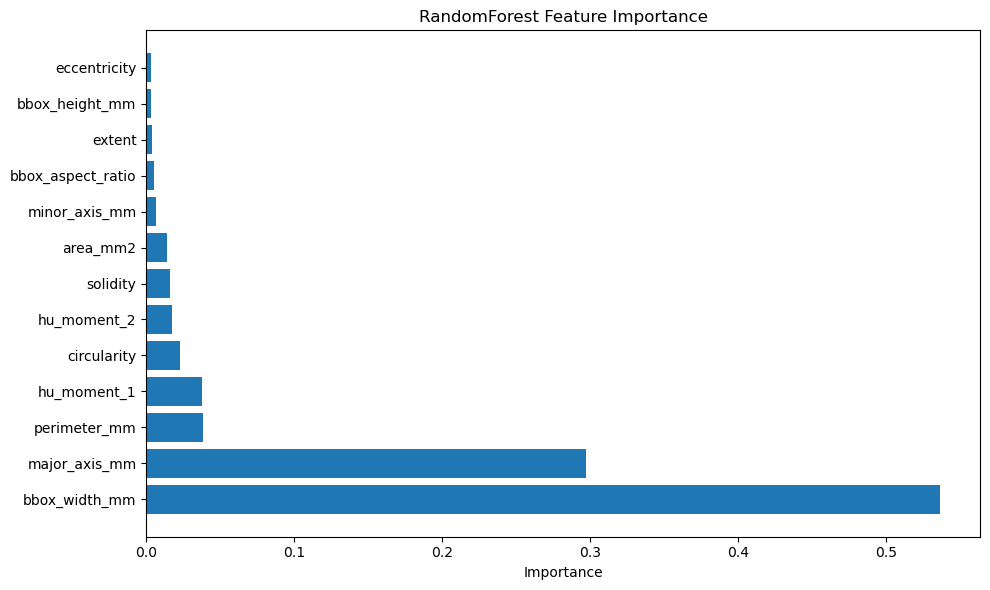

In [21]:
if hasattr(results[best_model_name]['best_model'], 'feature_importances_'):
    importances = results[best_model_name]['best_model'].feature_importances_
    feature_names = X.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(importance_df.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title(f'{best_model_name} Feature Importance')
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} does not have feature_importances_ attribute")